# In this notebook I write the routine for TOF spectrum calibration

        What it should be done:
        - read the theoretical spectrum
        - read the calibration sample
        - be able to convert from TOF to lambda and back
        - calculate T0 and deltaL, which are the results of the calibration 
        
        time to lambda convertion:
            lambda = h/mL (t-t0)
            where:lambda = wavelength [A] (A=0.1nm = 1e-10m)
                    h = Planck's constant: 6.62607004 × 10-34 m^2 kg / s
                    m = Neutron mass [kg]: 1.674 927 471 x 10-27 kg 
                    L = total flight path [m]
                    t = time of flight [s]
                    
        

In [29]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os, fnmatch
from os import listdir
%matplotlib inline
import scipy.signal
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

print(scipy.__version__)


1.1.0


In [2]:
# Constant values
h=6.62607004e-34 #Planck constant [m^2 kg / s]
m=1.674927471e-27 #Neutron mass [kg]
t0=0
L= 56.4 #[m]
dL = 0

In [3]:
def tof2l(tof):
    l=h/m*(tof-t0)/(L+dL)/1e-10
    return l

def l2tof(l):
    tof=t0+(l*1e-10)*(L+dL)*m/h
    return tof

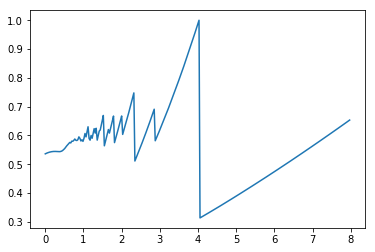

In [5]:
mylambda = np.genfromtxt('lambda.txt',usecols=0)
myspectrum = np.genfromtxt('alpha.txt',usecols=0)

# print(mylambda)
mytof = l2tof(mylambda)
relambda = tof2l(mytof)
plt.plot(mylambda, myspectrum/max(myspectrum))
plt.show()


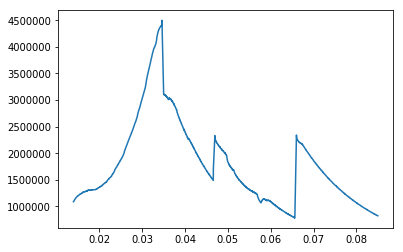

In [6]:
# Read the calibration spectrum from file
mycaltof = np.genfromtxt('C:/Users/imat/Documents/PSI-python/samples_after_reboot_OC_Fiji/IMAT00010420_HighStats_Radio_1hruns_000_Spectra.txt', usecols=0)
myhist = np.genfromtxt('C:/Users/imat/Documents/PSI-python/samples_after_reboot_OC_Fiji/IMAT00010420_HighStats_Radio_1hruns_000_Spectra.txt', usecols=1) #this is the cumulative histogram of the raw data (before the overlap correction)

plt.plot(mycaltof,myhist)
plt.show()

In [7]:
# Read the calibration datasets:
pathdata ="C:/Users/imat/Documents/PSI-python/samples_after_reboot_OC_Fiji/"
pathOB = "C:/Users/imat/Documents/PSI-python/flat_after_reboot_OC_Fiji/"

In [8]:
myfiles = fnmatch.filter(listdir(pathdata),'*.fits')
coll_files = sorted(myfiles)
print(coll_files[504])
print(coll_files[505])
print(coll_files[506])

obfiles = fnmatch.filter(listdir(pathOB),'*.fits') # here there are several OB folders
coll_ob = sorted(obfiles)
print(coll_ob[504])
print(coll_ob[505])
print(coll_ob[506])
# print(sorted(obfiles))

IMAT00010420_HighStats_Radio_1hruns_000_00504.fits
IMAT00010420_HighStats_Radio_1hruns_000_00505.fits
IMAT00010420_HighStats_Radio_1hruns_000_00506.fits
IMAT00010421_HighStats_Radio_1hruns_000_00504.fits
IMAT00010421_HighStats_Radio_1hruns_000_00505.fits
IMAT00010421_HighStats_Radio_1hruns_000_00506.fits


In [ ]:
# here I don't have repeated measurement for the OB for the cal sample

# # normalized_sample = np.zeros([512,512,len(coll_files)])
# obsubfiles = [None]*len(obfiles)

# for i in range(0, len(obfiles)):
# #     print(obfiles[i])
#     obsubfiles[i]= sorted(fnmatch.filter(listdir(pathOB+obfiles[i]+'/Corrected'),'*.fits')) 

# print(obsubfiles[2][0])

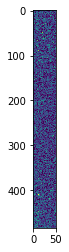

In [13]:
roi_cal = np.array([6,16,57,500])
filename = pathdata + coll_files[0]
im = fits.open(filename)
plt.imshow(im[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]) #this is the area that I want to study

In [15]:
cal_spectrum = np.zeros(len(coll_files))
cal_ob = np.zeros(len(coll_files))
ori_hist = np.zeros(len(coll_files))

for i in range(0, len(coll_files)):
    
    curr_img = (fits.open(pathdata+coll_files[i])[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]).astype(float)
    curr_ob =(fits.open(pathOB+coll_ob[i])[0].data[roi_cal[1]:roi_cal[3],roi_cal[0]:roi_cal[2]]).astype(float)
    cal_spectrum[i] = np.sum(curr_img[~np.isnan(curr_img) & ~np.isinf(curr_img)])
    cal_ob[i]= np.sum(curr_ob[~np.isnan(curr_ob) & ~np.isinf(curr_ob)])
    
    

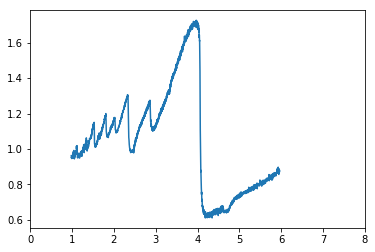

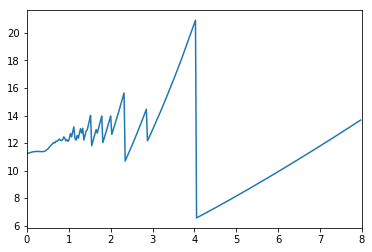

In [24]:
cal_spectrum_norm = -1*np.log(cal_spectrum/cal_ob)
mycalLambda = tof2l(mycaltof)
plt.plot(mycalLambda, -1*np.log(cal_spectrum/cal_ob))
plt.xlim(0,8)
plt.show()

myspectrum_norm = myspectrum/np.average(myspectrum)
plt.plot(mylambda, myspectrum)
plt.xlim(0,8)
plt.show()

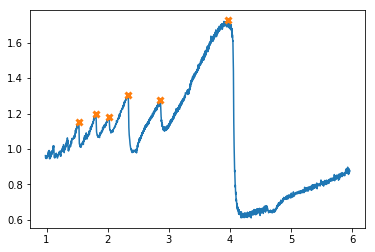

[1.52787084 1.80655379 2.02203139 2.32657587 2.86160842 3.96781794]


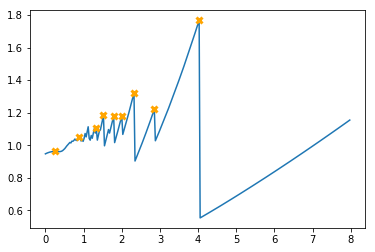

[0.24  0.88  1.333 1.52  1.787 2.    2.32  2.853 4.027]


In [43]:

# yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3
peaks, _ = find_peaks(cal_spectrum_norm, width=15)
plt.plot(mycalLambda, cal_spectrum_norm)
plt.plot(mycalLambda[peaks],cal_spectrum_norm[peaks],'x', markeredgewidth=3)
# plt.ylim(0.8,1.02)
plt.show()
print(mycalLambda[peaks])

peaks_th, _ = find_peaks(myspectrum_norm, width=2)
plt.plot(mylambda, myspectrum_norm)
plt.plot(mylambda[peaks_th],myspectrum_norm[peaks_th],'x', markeredgewidth=3, c='orange')
# plt.ylim(0.3,1.02)
plt.show()
print(mylambda[peaks_th])

## I will then fit the calculated TOF to the theoretical lambda, x= mylambda y=mycaltof 

[0.01384362 0.00101174]
[1.52787084 1.80655379 2.02203139 2.32657587 2.86160842 3.96781794]
[1.52  1.787 2.    2.32  2.853 4.027]


Text(0.5,1,'Calibration plot')

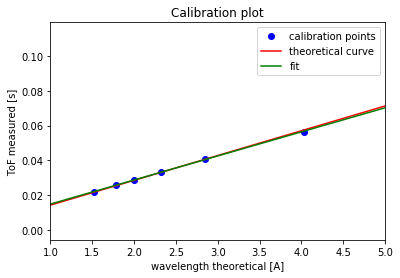

In [50]:
z = np.polyfit(mylambda[peaks_th[3:]],mycaltof[peaks[:]],1) # here I have to select which peaks to be used
print(z)
print(mycalLambda[peaks[:]])
print(mylambda[peaks_th[3:]])


plt.plot( mylambda[peaks_th[3:]],mycaltof[peaks[0:6]],'ob')
plt.plot( mylambda, mytof,'-r')
plt.plot(mylambda, mylambda*z[0]+z[1],'-g')
plt.xlim(1,5)
plt.xlabel('wavelength theoretical [A]')
plt.ylabel('ToF measured [s]')
# plt.ylim(0.0,0.03)
plt.legend(['calibration points','theoretical curve', 'fit'])
plt.title('Calibration plot')


In [38]:
T0 = z[1]
L = (z[0]*h/m)/1e-10
print(T0,L)

0.001011743793584796 54.76581570097706
